In [1]:
from numba import cuda

device = cuda.get_current_device(); device.reset()

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import os
import urllib.request
from tqdm import tqdm
from transformers import BertTokenizer, TFBertForSequenceClassification

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x1fc2cb73730>)

In [4]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [5]:
data

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [6]:
data['labels'] = data['labels'].replace(['negative', 'neutral', 'positive'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,1,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,1,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,0,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,2,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,2,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [7]:
del data['kor_sentence']

In [8]:
data[:5]

,labels,sentence
0,1,"According to Gran, the company has no plans to..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company's updated strategy fo...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    4846 non-null   int64 
 1   sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [10]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [11]:
print('kor_sentence 열의 유니크한 값 :',data['sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4838


In [12]:
duplicate = data[data.duplicated()]

In [13]:
duplicate

,labels,sentence
1099,1,The issuer is solely responsible for the conte...
1416,1,The report profiles 614 companies including ma...
2396,1,Ahlstrom's share is quoted on the NASDAQ OMX H...
2567,1,SSH Communications Security Corporation is hea...
3094,1,Proha Plc ( Euronext :7327 ) announced today (...
3206,1,The company serves customers in various indust...


In [14]:
# 중복 제거
data.drop_duplicates(subset=['sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4838


<Axes: xlabel='labels'>

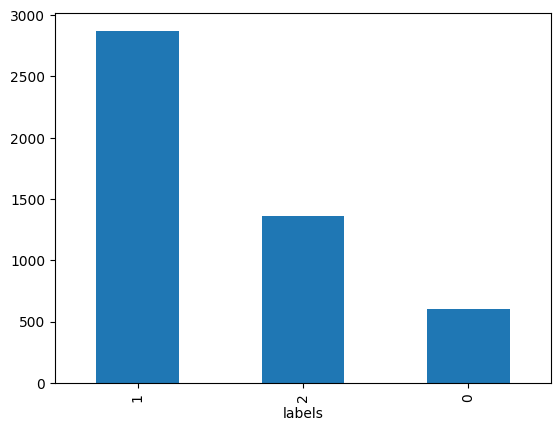

In [15]:
data['labels'].value_counts().plot(kind='bar')

In [16]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0    604
1       1   2872
2       2   1362


In [17]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')

중립의 비율 = 59.363%
긍정의 비율 = 28.152%
부정의 비율 = 12.484%


In [18]:
data

,labels,sentence
0,1,"According to Gran, the company has no plans to..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company's updated strategy fo...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai's beer sales fell by 6.5 per cent t...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


In [19]:
X_data = data['sentence']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4838
레이블의 개수: 4838


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [21]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3870
테스트 샘플의 개수 : 968


In [22]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.354%
긍정 = 28.165%
부정 = 12.481%


In [23]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.401%
긍정 = 28.099%
부정 = 12.5%


In [24]:
max_seq_len = 128

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [27]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)

        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

        # token_type_id은 세그먼트 인코딩 -> 문장 2개를 분류나 해석하는 task에선 각 문장이 0과 1로 분류됨.
        token_type_id = [0] * max_seq_len

        # 길이가 다를시 오류메세지 띄워줌.
        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [28]:
X_train, y_train, max_seq_len

(4328              Most of the layoffs will be in Finland.
 1558    LONDON ICIS -- Tikkurila has completed the sal...
 3582    Exel's board of directors will propose a divid...
 3454    Virala Oy Ab was allocated by the Board of Dir...
 2002    In China, Finnish Kone that provides elevators...
                               ...                        
 2513    mr Bakman sees also expansion options on the T...
 1613    The company designs, manufactures and markets ...
 3616    In 2007, the Group's net sales stood at EUR 42...
 4078    TietoEnator was down 1.13 pct to 18.38, extend...
 328     EPS for the quarter came in at 0.36 eur, up fr...
 Name: sentence, Length: 3870, dtype: object,
 4328    0
 1558    1
 3582    1
 3454    1
 2002    2
        ..
 2513    1
 1613    1
 3616    1
 4078    0
 328     2
 Name: labels, Length: 3870, dtype: int64,
 128)

In [29]:
train_X, train_y = convert_examples_to_features(X_train, y_train, max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/3870 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\yoonsung\anaconda3\envs\capston\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3870/3870 [00:01<00:00,

In [30]:
train_X, train_y

((array([[  101,  2087,  1997, ...,     0,     0,     0],
         [  101,  2414, 24582, ...,     0,     0,     0],
         [  101,  4654,  2884, ...,     0,     0,     0],
         ...,
         [  101,  1999,  2289, ...,     0,     0,     0],
         [  101,  5495,  3406, ...,     0,     0,     0],
         [  101, 20383,  2005, ...,     0,     0,     0]]),
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 array([0, 1, 1, ..., 1, 0, 2]))

In [31]:
test_X, test_y = convert_examples_to_features(X_test, y_test, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 968/968 [00:00<00:00, 2326.84it/s]


In [32]:
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [  101  2087  1997  1996  3913 27475  2097  2022  1999  6435  1012   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [33]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertForSequenceClassification, AdamW

In [34]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [35]:
len(train_X[0]), len(train_y)

(3870, 3870)

In [36]:
# create Tensor datasets
train_data = TensorDataset(torch.tensor(train_X[0]), torch.tensor(train_X[1]), torch.tensor(train_X[2]), torch.tensor(train_y))
valid_data = TensorDataset(torch.tensor(test_X[0]), torch.tensor(test_X[1]), torch.tensor(test_X[2]), torch.tensor(test_y))

# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [37]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
epochs = 5
valid_loss_min = np.Inf

train_loss = torch.zeros(epochs)
valid_loss = torch.zeros(epochs)

train_acc = torch.zeros(epochs)
valid_acc = torch.zeros(epochs)

model.to(device)
for e in tqdm(range(0, epochs)):
    model.train()
    # initialize hidden state 
    # h = model.init_hidden(batch_size)
    for inputs in tqdm(train_loader):
        input_ids = inputs[0].to(device)
        attention_mask = inputs[1].to(device)
        labels = inputs[3].type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = output.loss
        train_loss[e] += loss.item()
        loss.backward()
        
        # calculating accuracy
        # accuracy = acc(output,labels)
        ps = F.softmax(output.logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
        
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        # nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    train_loss[e] /= len(train_loader)
    train_acc[e] /= len(train_loader)

    
    model.eval()
    for inputs in tqdm(valid_loader):
        input_ids = inputs[0].to(device)
        attention_mask = inputs[1].to(device)
        labels = inputs[3].type(torch.LongTensor).to(device)

        output = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss = output.loss
        valid_loss[e] += val_loss.item()

        ps = F.softmax(output.logits, dim=1)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.reshape(top_class.shape)
        valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
    valid_loss[e] /= len(valid_loader)
    valid_acc[e] /= len(valid_loader)
    
    print(f'Epoch {e+1}') 
    print(f'train_loss : {train_loss[e]}, val_loss : {valid_loss[e]}')
    print(f'train_accuracy : {train_acc[e]*100}, val_accuracy : {valid_acc[e]*100}')
    if valid_loss[e] <= valid_loss_min:
        torch.save(model, 'bert_model.pth')
        torch.save(model.state_dict(), 'bert_model_state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss[e]))
        valid_loss_min = valid_loss[e]
    print(25*'==')

In [39]:
import os
path='C:/Users/yoonsung/Desktop/hlsw/capston/articles/'

In [40]:
news_df = pd.DataFrame(columns=["title","content"])

for txts in os.listdir(path):
    txt_file = open(path + txts, "r", encoding="UTF-8")
    title = txt_file.readline().strip()
    content = txt_file.read().replace('\n', ' ')
    data = pd.DataFrame({"title" : [title], "content" : [content]})
    news_df = pd.concat([news_df, data], ignore_index = True)
news_df

,title,content
0,"Tue, 02 Apr 2024 13:07:16 GMT",Tesla shares fell on Tuesday after the compan...
1,"Tue, 02 Apr 2024 15:04:21 GMT",Jim Cramer's daily rapid fire looks at stocks...
2,"Tue, 02 Apr 2024 13:07:11 GMT","In the first quarter, we produced over 433,00..."
3,"Tue, 02 Apr 2024 13:43:11 GMT",Wedbush analyst Daniel Ives reiterated an Out...
4,"Tue, 02 Apr 2024 15:23:11 GMT",Tesla (NASDAQ: TSLA) 30-day option implied vo...
...,...,...
67,"Tue, 02 Apr 2024 12:20:09 GMT",Tesla (NASDAQ: TSLA) stock is falling in the ...
68,"Tue, 02 Apr 2024 13:49:19 GMT",Vehicle production fell 1.7% year over year a...
69,"Tue, 02 Apr 2024 13:31:34 GMT",Tesla’s new Mannequin 3 sedans wait round to ...
70,"Wed, 03 Apr 2024 00:36:00 GMT",March was another tough month for Tesla (NASD...


In [41]:
# 데이터프레임의 'title'과 'content'를 이용하여 입력 데이터 생성
inputs = [content for content in news_df['content']]

# 입력 데이터를 BERT 모델의 입력 형식에 맞게 변환
max_length = 128
input_ids = []
attention_masks = []

for content in inputs:
    encoded_dict = tokenizer.encode_plus(
                        content,                    # content
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

c:\Users\yoonsung\anaconda3\envs\capston\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [42]:
predict_model = torch.load("bert_model_loss0.34.pth")
predict_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [43]:
predicted_labels = []

for inputs in tqdm(zip(input_ids, attention_masks)):
    input_ids = inputs[0].to(device)
    attention_mask = inputs[1].to(device)
    output = predict_model(input_ids, attention_mask=attention_mask)

    ps = F.softmax(output.logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    predicted_labels.append(top_class.item())

predict_df = pd.DataFrame({'predicted_label': predicted_labels})
news_df["predict"] = predict_df
news_df.to_csv('predicted_news.csv', index=False)

72it [00:03, 23.72it/s]


In [44]:
news_df

,title,content,predict
0,"Tue, 02 Apr 2024 13:07:16 GMT",Tesla shares fell on Tuesday after the compan...,0
1,"Tue, 02 Apr 2024 15:04:21 GMT",Jim Cramer's daily rapid fire looks at stocks...,1
2,"Tue, 02 Apr 2024 13:07:11 GMT","In the first quarter, we produced over 433,00...",0
3,"Tue, 02 Apr 2024 13:43:11 GMT",Wedbush analyst Daniel Ives reiterated an Out...,0
4,"Tue, 02 Apr 2024 15:23:11 GMT",Tesla (NASDAQ: TSLA) 30-day option implied vo...,0
...,...,...,...
67,"Tue, 02 Apr 2024 12:20:09 GMT",Tesla (NASDAQ: TSLA) stock is falling in the ...,0
68,"Tue, 02 Apr 2024 13:49:19 GMT",Vehicle production fell 1.7% year over year a...,0
69,"Tue, 02 Apr 2024 13:31:34 GMT",Tesla’s new Mannequin 3 sedans wait round to ...,1
70,"Wed, 03 Apr 2024 00:36:00 GMT",March was another tough month for Tesla (NASD...,0


<Axes: xlabel='predict'>

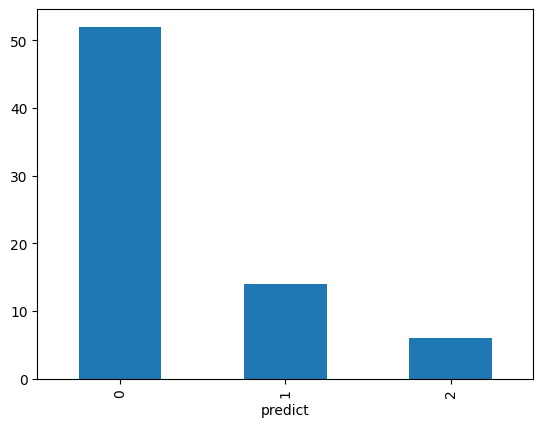

In [45]:
news_df['predict'].value_counts().plot(kind='bar')